# ALeRCE API interaction examples

Load libraries

In [1]:
import sys
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from pandas.io.json import json_normalize
from astropy.time import Time
from datetime import datetime
from IPython.display import HTML

In [2]:
#!pip install alerce
from alerce.api import AlerceAPI

See https://github.com/alercebroker/usecases/blob/master/api/ALeRCE%20ZTF%20DB%20API.md

In [3]:
# continuously load modules (for easier debugging)
%load_ext autoreload
%autoreload 2

# Initialize alerce api object

In [5]:
client = AlerceAPI()

# Classifier taxonomy and numeric mappings

There are two classifiers used in ALeRCE, an early classifier and a late classifier. Each one has its own numeric mappings for the different classes. You can use their string or integer names.

The early classifier uses as input the first detection stamps and contains the following classes:

    "agn"
    "sn"
    "vs"
    "asteroid"
    "bogus"
    
The late classifier uses the light curve information and contains the following classes:

    "sn ia"
    "sn ibc"
    "sn ii"
    "sn iin"
    "slsn"
    "eb/sd/d"
    "eb/c"
    "periodic/other"
    "cv/nova"
    "blazar"
    "agn i"
    "dsct"
    "ceph"
    "lpv"
    "rrl"
    "other"

# 1. query

Query a list of objects

The following json file should be sent

```js
{
total: number, // (if not set the total is counted and the query is slower),
records_per_pages: number. // default 20
page: number (default 1),
sortBy: string columnName, // default nobs
query_parameters:{
    filters:{
        //ZTF Object id
        oid: "ZTFXXXXXX",
        //Number of detections
        nobs: { 
            min: int
            max: int
        },
        //Late Classifier (Random Forest)
        classrf: int,
        pclassrf: float [0-1],
        //Early Classifier (Stamp Classifier)
        classearly: int,
        pclassearly: float [0-1],
    },
    //Coordinate based search (RA,DEC) and Search Radius.
    coordinates:{
        ra: float degrees,
        dec: float degrees,
        sr: float degrees
    },
    dates:{
        //First detection (Discovery date)
        firstmjd: {
         min: float mjd,
         max: float mjd
        }
    }
}
```

### Example: 

Give me all the objects with probability of being SNe greater than 0.8 according to the random forest classifier (light curve based), which have between 2 and 40 detections. Give me the second page, with pages of 10 elements each, of a total of at most 40 objects query result.

Note: probabilities are experimental and should not be fully trusted

In [6]:
total = 40
records_per_page = 10
page = 2
sortBy = "firstmjd"
nobsmin = 10
nobsmax = 40
classrf = "sn ia"
pclassrf = 0.3

params = {
    "total": total,
    "records_per_pages": records_per_page,
    "page": page,
    "sortBy": sortBy,
    "query_parameters": {
        "filters": {
            "nobs": { 
                "min": nobsmin,
                "max": nobsmax
            },
            "classrf": classrf,
            "pclassrf": pclassrf
        }
    }
}

In [7]:
query_results = client.query(params, format='pandas')
query_results.head()

,catalogid,classearly,classrf,classxmatch,deltajd,first_magap_g,first_magap_r,first_magpsf_g,first_magpsf_r,firstmjd,...,nobs,pclassearly,pclassrf,period,sigma_magap_g,sigma_magap_r,sigma_magpsf_g,sigma_magpsf_r,sigmadec,sigmara
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19acbswdq,None,19,10,None,36.979502,18.224600,19.533701,18.298929,19.195061,58757.321574,...,18,1.000000,0.320,None,0.596910,0.505103,0.629876,0.419458,0.000026,0.000031
ZTF19acbpqvc,None,21,10,None,36.956991,18.699100,17.611601,18.658756,17.566465,58757.193507,...,19,0.913192,0.304,None,0.695959,0.414347,0.674953,0.387222,0.000014,0.000010
ZTF19acbmyqe,None,19,10,None,38.066794,19.536400,18.984699,19.618511,18.816895,58756.475081,...,17,0.985974,0.302,None,0.673687,0.258330,0.494808,0.305881,0.000041,0.000033
ZTF19acbmotn,None,18,10,None,37.050312,19.993601,20.156099,19.656010,19.728617,58756.454201,...,16,0.766637,0.300,None,0.382541,0.454579,0.303711,0.378040,0.000050,0.000065
ZTF19acbmjrp,None,21,10,None,36.917651,19.325701,19.537300,19.450378,19.551464,58756.440069,...,17,0.999191,0.324,None,0.576307,0.335006,0.565661,0.348101,0.000028,0.000036


### Example: 

Give me the last 100 objects with classified as SNe according to the early classifier (one image stamp)

Note: this is experimental, about 90% of the candidates are false positives

In [11]:
mjd_48hr = Time(datetime.utcnow(), scale='utc').mjd - 2.

total = 100
records_per_page = 100
sortBy = "pclassearly"
classearly = 'sn'

params = {
    "total": total,
    "records_per_pages": records_per_page,
    "sortBy": sortBy,
    "query_parameters": {
        "filters": {
            "classearly": classearly
        },
        "dates": {
            "firstmjd": {
                "min": mjd_48hr
            }
        }
    }
}

In [12]:
query_results = client.query(params, format='pandas')
query_results.head()

,catalogid,classearly,classrf,classxmatch,deltajd,first_magap_g,first_magap_r,first_magpsf_g,first_magpsf_r,firstmjd,...,nobs,pclassearly,pclassrf,period,sigma_magap_g,sigma_magap_r,sigma_magpsf_g,sigma_magpsf_r,sigmadec,sigmara
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19acpowjm,None,20,None,None,0.0,17.1663,None,17.269,None,58794.237315,...,1,0.999903,None,None,None,None,None,None,None,None
ZTF19acqdqbf,None,20,None,None,0.0,17.0227,None,17.2785,None,58794.544965,...,1,0.999789,None,None,None,None,None,None,None,None
ZTF19acpmxhd,None,20,None,None,0.0,None,14.3329,None,14.343,58794.112905,...,1,0.999375,None,None,None,None,None,None,None,None
ZTF19acpnceh,None,20,None,None,0.0,None,16.849,None,16.673,58794.115243,...,1,0.999351,None,None,None,None,None,None,None,None
ZTF19acqnnuq,None,20,None,None,0.0,12.4965,None,12.4983,None,58795.115856,...,1,0.999327,None,None,None,None,None,None,None,None


(19.83511572552409, 11.746904127784129)

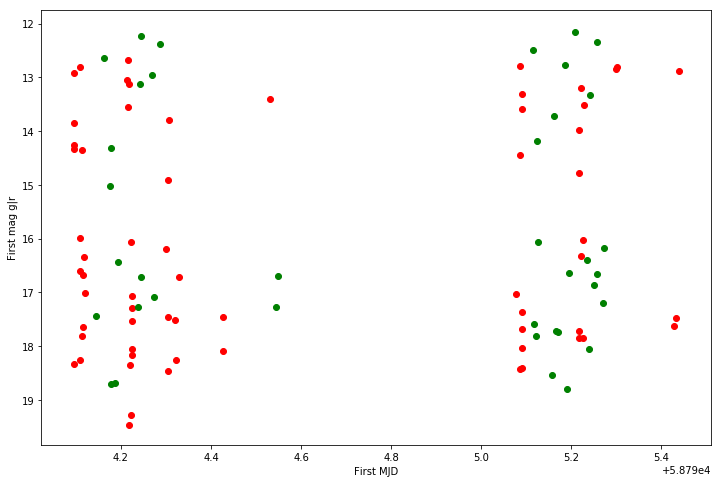

In [13]:
# Show first mag vs first MJD
fig, ax = plt.subplots(figsize = (12, 8))
mask = query_results.first_magpsf_r.notnull()
ax.scatter(query_results.firstmjd[mask], query_results.first_magpsf_r[mask], c = 'r')
mask = query_results.first_magpsf_g.notnull()
ax.scatter(query_results.firstmjd[mask], query_results.first_magpsf_g[mask], c = 'g')
ax.set_xlabel("First MJD")
ax.set_ylabel("First mag g|r")
ax.set_ylim(ax.get_ylim()[::-1])

You can see the ZTF filter changes during the night. The missing times are due to the ZTF private stream.

# 2. get_sql

Get the sql query using the same parameters as the previous query

In [14]:
client.get_sql(params)

'SELECT * FROM objects WHERE classearly=20 AND  firstmjd >= 58793.83037176905 '

# 3. get_detections

Get all the detections for an object

In [16]:
oid = "ZTF19abueupg"

In [18]:
detections = client.get_detections(oid, format='pandas')
display(detections.head())
", ".join(list(detections))

,candid_str,dec,diffmaglim,distpsnr1,fid,field,isdiffpos,magap,magap_corr,magnr,...,rb,rcid,sgscore1,sigmadec,sigmagap,sigmagap_corr,sigmagnr,sigmapsf,sigmapsf_corr,sigmara
candid,,,,,,,,,,,,,,,,,,,,,
970313001115015006,970313001115015006,51.382551,20.446541,5.113520,1,797,1,19.706900,19.706900,20.913000,...,0.920000,11,0.5,0.09,0.1900,0.1900,0.085,0.139590,0.139590,0.09
971263501115015039,971263501115015039,51.382555,20.572720,5.004293,2,797,1,19.548800,19.548800,19.693001,...,0.592857,11,0.5,0.09,0.1692,0.1692,0.130,0.155431,0.155431,0.09
971289301115015006,971289301115015006,51.382573,20.407963,5.065497,1,797,1,19.450300,19.450300,20.913000,...,0.877143,11,0.5,0.09,0.1279,0.1279,0.085,0.099974,0.099974,0.09
972264951115015027,972264951115015027,51.382526,20.445602,5.038084,2,797,1,18.945101,18.945101,19.693001,...,0.934286,11,0.5,0.09,0.1063,0.1063,0.130,0.093884,0.093884,0.09
972290601115015008,972290601115015008,51.382546,20.350231,5.046748,1,797,1,19.068300,19.068300,20.913000,...,0.951429,11,0.5,0.09,0.1081,0.1081,0.085,0.096079,0.096079,0.09


'candid_str, dec, diffmaglim, distpsnr1, fid, field, isdiffpos, magap, magap_corr, magnr, magpsf, magpsf_corr, mjd, oid, ra, rb, rcid, sgscore1, sigmadec, sigmagap, sigmagap_corr, sigmagnr, sigmapsf, sigmapsf_corr, sigmara'

# 4. get_non_detections

In [19]:
non_detections = client.get_non_detections(oid, format='pandas')
non_detections.head()

,diffmaglim,fid,oid
mjd,,,
58695.278808,18.942801,2,ZTF19abueupg
58695.308171,20.085800,1,ZTF19abueupg
58696.280255,20.712299,2,ZTF19abueupg
58696.309468,20.865499,1,ZTF19abueupg
58697.302245,20.648100,2,ZTF19abueupg


(21.145861079607084, 15.147731491110696)

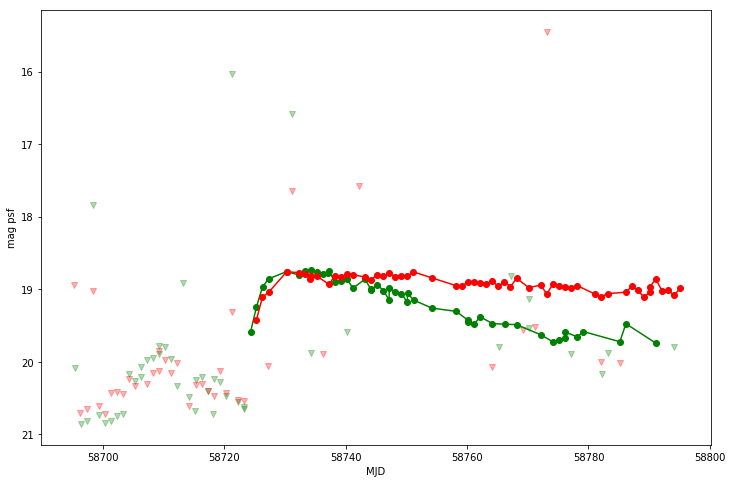

In [20]:
fig, ax = plt.subplots(figsize = (12, 8))
colors = ["g", "r"]
for fid in [1, 2]:
    mask = detections.fid == fid
    ax.plot(detections.mjd[mask], detections.magpsf[mask], c = colors[fid - 1], marker = "o")
    mask = non_detections.fid == fid
    # note that the index of non-detectionsis the mjd
    ax.scatter(non_detections.index[mask], non_detections.diffmaglim[mask], c = colors[fid - 1], marker = "v", alpha=0.3)
ax.set_xlabel("MJD")
ax.set_ylabel("mag psf")
ax.set_ylim(ax.get_ylim()[::-1])

# 5. get_stats

In [22]:
stats = client.get_stats(oid, format='pandas')
display(stats)
stats.keys()

oid                ZTF19abueupg
nobs                        104
mean_magap_g            19.1966
mean_magap_r            18.9215
median_magap_g          19.1547
median_magap_r          18.8601
max_magap_g             20.2068
max_magap_r             19.5804
min_magap_g             18.5337
min_magap_r             18.6207
sigma_magap_g          0.398469
sigma_magap_r          0.227407
last_magap_g            19.8079
last_magap_r             19.124
first_magap_g           19.7069
first_magap_r           19.5488
mean_magpsf_g           19.1934
mean_magpsf_r           18.9291
median_magpsf_g         19.1484
median_magpsf_r         18.9328
max_magpsf_g            19.7455
max_magpsf_r            19.4284
min_magpsf_g            18.7283
min_magpsf_r            18.7589
sigma_magpsf_g         0.335785
sigma_magpsf_r         0.120453
last_magpsf_g           19.7455
last_magpsf_r           18.9874
first_magpsf_g          19.5887
first_magpsf_r          19.4284
meanra                  267.803
meandec 

Index(['oid', 'nobs', 'mean_magap_g', 'mean_magap_r', 'median_magap_g',
       'median_magap_r', 'max_magap_g', 'max_magap_r', 'min_magap_g',
       'min_magap_r', 'sigma_magap_g', 'sigma_magap_r', 'last_magap_g',
       'last_magap_r', 'first_magap_g', 'first_magap_r', 'mean_magpsf_g',
       'mean_magpsf_r', 'median_magpsf_g', 'median_magpsf_r', 'max_magpsf_g',
       'max_magpsf_r', 'min_magpsf_g', 'min_magpsf_r', 'sigma_magpsf_g',
       'sigma_magpsf_r', 'last_magpsf_g', 'last_magpsf_r', 'first_magpsf_g',
       'first_magpsf_r', 'meanra', 'meandec', 'sigmara', 'sigmadec', 'deltajd',
       'lastmjd', 'firstmjd', 'period', 'catalogid', 'classxmatch', 'classrf',
       'pclassrf', 'pclassearly', 'classearly'],
      dtype='object')

# 6. get_probabilities

In [23]:
probs = client.get_probabilities(oid, format='pandas')
display(probs["early"])
display(probs["late"])

oid                   ZTF19abueupg
agn_prob               1.47033e-09
sn_prob                   0.999992
vs_prob                 1.6456e-07
asteroid_prob          7.57048e-06
classifier_version            None
bogus_prob             8.68233e-09
dtype: object

oid                    ZTF19abueupg
AGN-I_prob                     0.06
Blazar_prob                   0.114
CV/Nova_prob                  0.022
SNIa_prob                     0.046
SNIbc_prob                    0.068
SNII_prob                     0.232
SNIIn_prob                     0.11
SLSN_prob                       0.1
EBSD/D_prob                   0.016
EBC_prob                      0.016
DSCT_prob                     0.012
RRL_prob                      0.038
Ceph_prob                     0.048
LPV_prob                      0.094
Periodic-Other_prob           0.024
dtype: object

# 7. get_features

In [24]:
features = client.get_features(oid, format='pandas')
features

oid                    ZTF19abueupg
n_samples_1                      47
Amplitude_1                0.491896
AndersonDarling_1          0.999956
Autocor_length_1                 10
Beyond1Std_1               0.382979
Con_1                             0
Eta_e_1                   0.0874861
Gskew_1                    0.175563
MaxSlope_1                  3.38831
Mean_1                      19.1934
Meanvariance_1            0.0173077
MedianAbsDev_1             0.301222
MedianBRP_1                 0.12766
PairSlopeTrend_1           0.366667
PercentAmplitude_1        0.0311829
Q31_1                      0.589397
PeriodLS_v2_1               1.01082
Period_fit_v2_1                   0
Psi_CS_v2_1                0.276381
Psi_eta_v2_1               0.338092
Rcs_1                      0.449798
Skew_1                      0.20374
SmallKurtosis_1            -1.33937
Std_1                      0.332193
StetsonK_1                 0.890372
Harmonics_mag_1_1          0.465099
Harmonics_mag_2_1         0.

# 8. get_stamp

Get the stamps of an object.

See https://github.com/alercebroker/usecases/blob/master/api/ALeRCE%20AVRO-STAMP%20Access%20API.md

In [25]:
# note that the index of detections is the candid
print(oid)
client.plot_stamp(oid)
client.plot_stamp(oid, detections.index.min())
client.plot_stamp(oid, detections.index.max())

ZTF19abueupg
